# 实验8 卷积神经网络(CNN): 应用

目标:
- 使用Keras的API来构建一个二分类器
- 使用Keras的API来构建一个多分类器, 用于手势数字识别

<a name='1'></a>
## 1 - 包
本实验需使用第三方库pandas, 如未下载安装, 可以在虚拟环境中使用下面的命令进行安装
`pip install pandas`

In [27]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from lib_cnn_utils import *
from lib_test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

<a name='1-1'></a>
### 1.1 - 载入数据并将其划分为训练集和测试集
你将使用名为Happy House的数据集, 其包含人脸图片.
你的任务是构建一个卷积网络来识别图片中的人是否在微笑 -- 微笑的人才被允许进入房间!

In [28]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


你可以显示数据集中的图片, 这些图片为RGB颜色模式(即3通道)下分辨率为 **64x64** 的数据.

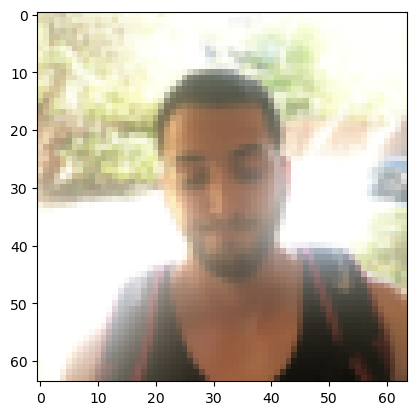

In [29]:
index = 124
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

<a name='2'></a>
## 2 - TF Keras中的网络层

之前的实验中, 你通过numpy来手动构建网络层. 在TF Keras中, 你可以直接调用预定义的网络层.

<a name='3'></a>
## 3 - The Sequential API

在实验的第一部分, 你将使用Keras的Sequential API来创建一个模型, 此API允许你逐层构建模型, 每层仅有一个输入张量和一个输出张量.

Sequential API非常简单和直观, 但只适合简单和直观的任务. 后面你会花时间探索另一种更为灵活和强大的选择: the Functional API.

<a name='3-1'></a>
### 3.1 - 创建一个顺序模型

你可以通过`.add()`/`.pop()`方法来为顺序模型添加/删除网络层.

你可以将顺序模型看做网络层的一个列表(类似与Python列表), 这些层存在顺序关系. 如果你的模型是非线性的或者某些层的输入/输出存在多个输入输出, 顺序模型可能并不适用!
对于任意Keras中创建的层, 你需要指定输入数据的形状. 这是因为一开始需要初始化权重, 而权值的尺寸是由输入的尺寸决定的.

<a name='ex-1'></a>
#### 练习 1 - happyModel

实现下面的 `happyModel` 函数来构建一个如下的模型: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. 帮助链接 [keras中文文档](https://keras.io/zh/)

 **提示:**
 
在import部分已指定 **tensorflow.keras.layers** 的别名为 **tfl**

In [7]:
"""
Function:
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes.
    Normally, functions should take these values as function parameters.
Returns:
    model -- TF Keras model (object containing the information for the entire training process)
"""
def happyModel():
    model = tf.keras.Sequential([
            # YOUR CODE STARTS HERE
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            # tfl.ZeroPadding2D(padding=..., input_shape=...),
            tf.keras.Input(shape=(64 , 64 ,3)),
            tfl.ZeroPadding2D(padding=3),
            ## Conv2D with 32 7x7 filters and stride of 1
            tfl.Conv2D(filters=32,kernel_size=7,strides=1),
            ## BatchNormalization for axis 3
            tfl.BatchNormalization(axis=3, momentum=0.99, epsilon=0.001),
            ## ReLU
            tfl.ReLU(),
            ## Max Pooling 2D with default parameters
            tfl.MaxPool2D(),
            ## Flatten layer
            tfl.Flatten(),
            ## Dense layer with 1 unit for output & 'sigmoid' activation
            tfl.Dense(1,activation='sigmoid')
            # YOUR CODE ENDS HERE
        ])
    
    return model

In [8]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


现在模型已经创建, 接下来你可以在compile函数中指定训练所需的优化器(optimizer)和损失函数(loss). 如果将`accuracy`(即准确率)指定给参数`metrics`(即评价指标), 其类型将自动根据损失函数进行转换.

In [9]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

接下来通过`.summary()`方法检查模型的参数. 其输出包含网络层的类型, 输出数据的形状, 以及每一层的参数量.

In [10]:
happy_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

<a name='3-2'></a>
### 3.2 - 模型训练和评价

通过 `.fit()` 方法可以开始模型训练, 其参数包括epoch数, 以及minibatch size.

In [30]:
happy_model.fit(X_train, Y_train, epochs=20, batch_size=16)

Epoch 1/20
38/38 [==============================] - 3s 75ms/step - loss: 0.0458 - accuracy: 0.9867
Epoch 2/20
38/38 [==============================] - 2s 65ms/step - loss: 0.0529 - accuracy: 0.9867
Epoch 3/20
38/38 [==============================] - 2s 61ms/step - loss: 0.0736 - accuracy: 0.9750
Epoch 4/20
38/38 [==============================] - 2s 59ms/step - loss: 0.0407 - accuracy: 0.9833
Epoch 5/20
38/38 [==============================] - 2s 60ms/step - loss: 0.1081 - accuracy: 0.9633
Epoch 6/20
38/38 [==============================] - 2s 61ms/step - loss: 0.0940 - accuracy: 0.9767
Epoch 7/20
38/38 [==============================] - 2s 60ms/step - loss: 0.0264 - accuracy: 0.9917
Epoch 8/20
38/38 [==============================] - 2s 61ms/step - loss: 0.0447 - accuracy: 0.9883
Epoch 9/20
38/38 [==============================] - 2s 59ms/step - loss: 0.0878 - accuracy: 0.9750
Epoch 10/20
38/38 [==============================] - 2s 57ms/step - loss: 0.0599 - accuracy: 0.9783
Epoch 11/

然后可以通过调用`.evaluate()`方法加载测试数据, 已完成进行评价. 该方法将打印损失函数值和性能指标值. 在本例中即 `binary_crossentropy` 和 `accuracy`.

In [31]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 23ms/step - loss: 0.7227 - accuracy: 0.8000


[0.7226663827896118, 0.800000011920929]

很简单对吧. 但是如果你要构建一个模型具有共享层, 分支或多个输入输出, 则需要使用下面的Functional API.

<a name='4'></a>
## 4 - The Functional API

欢迎来到本实验的第二部分, 你将使用Keras中灵活的[Functional API](https://www.tensorflow.org/guide/keras/functional) 来构建CNN, 以区分6种不同的手势数字.

功能性API能处理非线性拓扑结构的模型, 共享层, 以及具有多个输入输出的层. 如果说Sequential API是构建线性结构的模型(Sequential Movement), 那么Functional API则可以构建图结构的模型(例如下图中的Skip Connection).

<img src="images/seq_vs_func.png" width=600>

<a name='4-1'></a>
### 4.1 - 加载SIGNS数据集

如下图所示, SIGNS 数据集包含6中手势信号, 分别对应着数值0至5.
<img src="images/SIGNS.png" width=1000>
可通过下面的代码加载这些数据

In [39]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

运行下面的代码来显示载入的数据及其标签值.

y = 4


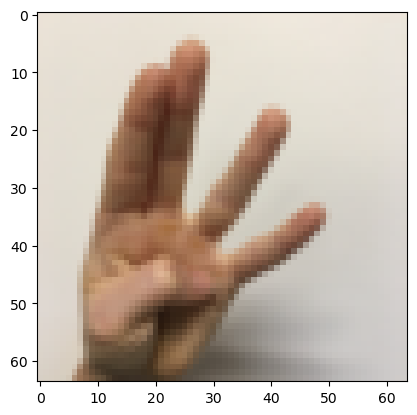

In [40]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

<a name='4-2'></a>
### 4.2 - 将数据拆分为训练集和测试集
首先让我们了解数据的形状尺寸

In [41]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


<a name='4-3'></a>
### 4.3 - 前向传播
在TF中预定义了实现卷积的函数. 其使用到计算图的概念.
下面的模型虽然也可以使用Sequential API来实现, 但在本练习中, 你将使用functional API.

<a name='ex-2'></a>
#### 练习 2 - convolutional_model

实现下面的 `convolutional_model` 函数来构建一个模型: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`.
要求:
使用上面的函数!

Also, plug in the following parameters for all the steps:

 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 4 by 4 filters, stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 2 by 2 filters, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 6 neurons and a softmax activation. 

In [42]:
"""
Function:
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes.
    Normally, functions should take these values as function parameters.
Arguments:
    input_img -- input dataset, of shape (input_shape)
Returns:
    model -- TF Keras model (object containing the information for the entire training process)
"""
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    # YOUR CODE STARTS HERE
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    # Z1 = None
    Z1 = tfl.Conv2D(filters= 8. , kernel_size=4 , padding='same',strides=1)(input_img)
    ## RELU
    # A1 = None
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    # P1 = None
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='SAME')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    # Z2 = None
    Z2 = tfl.Conv2D(filters= 16. , kernel_size=2 , padding='same',strides=1)(P1)
    ## RELU
    # A2 = None
    A2 =  tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    # P2 = None
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='SAME')(A2)
    ## FLATTEN
    # F = None
    F = tfl.Flatten()(P2)
    ## Dense layer: 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'"
    # outputs = None
    outputs = tfl.Dense(units= 6 , activation='softmax')(F)
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [43]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
    
comparator(summary(conv_model), output)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu_8 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 16)         

Sequential和Functional APIs都会返回一个Keras模型对象. 区别在于输入数据在模型中是如何处理的!

<a name='4-4'></a>
### 4.4 - 模型训练

In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=60, validation_data=test_dataset)

Epoch 1/60
17/17 [==============================] - 1s 44ms/step - loss: 1.8482 - accuracy: 0.1694 - val_loss: 1.7985 - val_accuracy: 0.1083
Epoch 2/60
17/17 [==============================] - 1s 37ms/step - loss: 1.7939 - accuracy: 0.1602 - val_loss: 1.7929 - val_accuracy: 0.1333
Epoch 3/60
17/17 [==============================] - 1s 39ms/step - loss: 1.7871 - accuracy: 0.1815 - val_loss: 1.7874 - val_accuracy: 0.1500
Epoch 4/60
17/17 [==============================] - 1s 37ms/step - loss: 1.7844 - accuracy: 0.2269 - val_loss: 1.7840 - val_accuracy: 0.2250
Epoch 5/60
17/17 [==============================] - 1s 39ms/step - loss: 1.7807 - accuracy: 0.2556 - val_loss: 1.7787 - val_accuracy: 0.3417
Epoch 6/60
17/17 [==============================] - 1s 39ms/step - loss: 1.7759 - accuracy: 0.2796 - val_loss: 1.7731 - val_accuracy: 0.3250
Epoch 7/60
17/17 [==============================] - 1s 37ms/step - loss: 1.7700 - accuracy: 0.3185 - val_loss: 1.7676 - val_accuracy: 0.3250
Epoch 8/60
17

<a name='5'></a>
## 5 - 历史对象

`.fit()`函数将返回一个历史对象, 其中以字典形式记录了所有的loss和评价指标数值. 通过命令`history.history`可以获取这些数据:

In [45]:
history.history

{'loss': [1.8482342958450317,
  1.793876051902771,
  1.7870627641677856,
  1.7843947410583496,
  1.7806923389434814,
  1.7759153842926025,
  1.769972324371338,
  1.7635129690170288,
  1.7500630617141724,
  1.734153151512146,
  1.7144383192062378,
  1.6896681785583496,
  1.6594644784927368,
  1.625153660774231,
  1.5864198207855225,
  1.5453118085861206,
  1.5037059783935547,
  1.4624650478363037,
  1.4222965240478516,
  1.3820964097976685,
  1.3445310592651367,
  1.3082919120788574,
  1.2746849060058594,
  1.2412782907485962,
  1.2079424858093262,
  1.1757941246032715,
  1.1453975439071655,
  1.1162691116333008,
  1.0892823934555054,
  1.062630295753479,
  1.0359019041061401,
  1.01055908203125,
  0.9858003854751587,
  0.9626099467277527,
  0.9396873712539673,
  0.9176303744316101,
  0.896420955657959,
  0.8766951560974121,
  0.857873797416687,
  0.839454174041748,
  0.8218719363212585,
  0.8045449256896973,
  0.7886990904808044,
  0.7735888957977295,
  0.7584639191627502,
  0.74423307

下面将可视化上述数值:

C:\Users\lijunhao\AppData\Local\Temp\ipykernel_24012\973814028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\lijunhao\AppData\Local\Temp\ipykernel_24012\973814028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

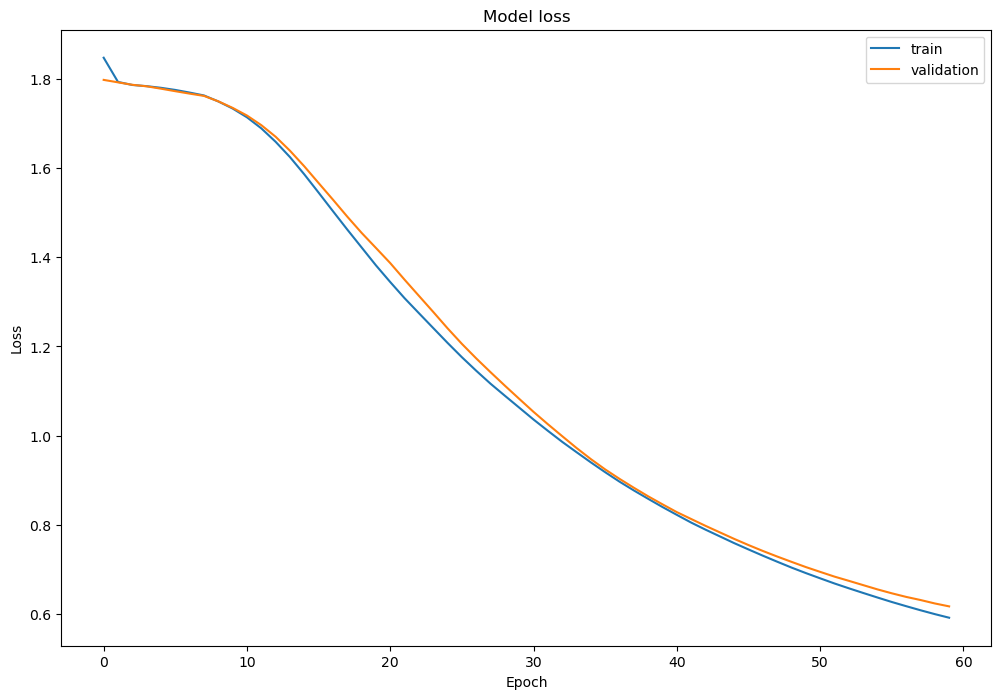

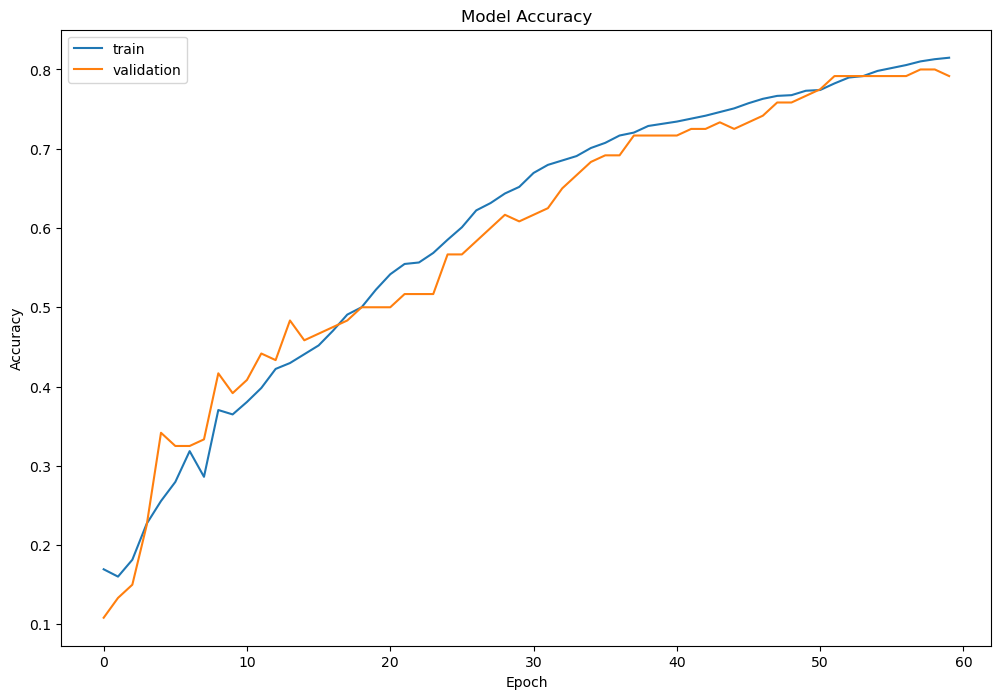

In [46]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

**Congratulations**! You've finished the assignment and built two models: One that recognizes  smiles, and another that recognizes SIGN language with almost 80% accuracy on the test set. In addition to that, you now also understand the applications of two Keras APIs: Sequential and Functional. Nicely done! 

By now, you know a bit about how the Functional API works and may have glimpsed the possibilities. In your next assignment, you'll really get a feel for its power when you get the opportunity to build a very deep ConvNet, using ResNets! 

<a name='6'></a>
## 6 - Bibliography

You're always encouraged to read the official documentation. To that end, you can find the docs for the Sequential and Functional APIs here: 

https://www.tensorflow.org/guide/keras/sequential_model

https://www.tensorflow.org/guide/keras/functional